In [1]:
import warnings

warnings.filterwarnings("ignore")

import ast
import itertools
import json
import math
import os
import re
import sys
from collections import Counter, deque
from copy import deepcopy
from functools import reduce
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from networkx.algorithms.shortest_paths.weighted import dijkstra_path_length
from rich import print
from scipy.signal import convolve2d
from tqdm import tqdm

In [2]:
def plot_mtx(mtx, figsize=(10, 10)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.matshow(mtx, cmap=plt.cm.Blues)
    plt.plot()

In [3]:
def read_file_to_str_li(fp, print_exp=True):
    with open(fp, "r") as f:
        lines = f.read().split("\n")
    if print_exp:
        print(f"Read from {fp}:")
        print(f"First line: {lines[0]} | Last line: {lines[-1]}")
        print("-" * 6)

    return lines


# define the function blocks
def convert_to_int(input_str):
    if input_str == "" or input_str == " ":
        return None
    return int(input_str)


def convert_to_str(input_str):
    return str(input_str)


# map the inputs to the function blocks
converts = {
    "i": convert_to_int,
    "s": convert_to_str,
}


def convert_str_li_to_other_li(
    str_li, pattern="i", per_letter=False, sep=" ", start_row=0, end_row=None
):
    """Convert a list of string to a list of other types

    pattern: a list of types for one item.
        'i' for int, 's' for string
        'si' means: convert the 1st item to string, the rest to integer
        If separated items are more than pattern items,
        use the last one from the parttern.
    if per_letter=True, ignore sep and separate item per letter
    """
    target_str_li = str_li[start_row:end_row]
    # find max item num
    max_item_num = 1
    if per_letter:
        max_item_num = max([len(s) for s in target_str_li])
    else:
        max_item_num = max([len(s.split(sep)) for s in target_str_li])

    # extend the pattern to the max itme num
    pattern = (
        pattern + f"{pattern[-1]}" * (max_item_num - len(pattern))
        if max_item_num > len(pattern)
        else pattern
    )

    # convert
    if per_letter:
        return [
            [converts[pattern[idx]](item) for idx, item in enumerate(s)]
            for s in target_str_li
        ]
    else:
        if sep == " ":
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split())]
                for s in target_str_li
            ]
        else:
            return [
                [converts[pattern[idx]](item) for idx, item in enumerate(s.split(sep))]
                for s in target_str_li
            ]

In [4]:
fp = "input.txt"
lines = read_file_to_str_li(fp)

print("Convert to:")

# head = convert_str_li_to_other_li(
#     lines, pattern="s", per_letter=True, sep=",", start_row=0, end_row=1
# )

# print(f"Head:\n{head}")
# print(f"First line: {head[0]}")
# print(f"Last line: {head[-1]}")

data = convert_str_li_to_other_li(
    lines, pattern="s", per_letter=True, sep=" ", start_row=None, end_row=None
)


print(f"First line: {data[0]}")
print(f"Last line: {data[-1]}")
print("-" * 6)

Read from input.txt:

First line: #.#.####.###...###..#....#.....##.#.#.#..#.#.#######...##...#..###..#.. | Last line: 
..##.##....##.###......#..##.###..##.##.####....#..#.##.....#.##.###.#.

------

Convert to:

First line: ['#', '.', '#', '.', '#', '#', '#', '#', '.', '#', '#', '#', '.', '.', '.', '#', '#', '#', '.', '.', 
'#', '.', '.', '.', '.', '#', '.', '.', '.', '.', '.', '#', '#', '.', '#', '.', '#', '.', '#', '.', '.', '#', '.', 
'#', '.', '#', '#', '#', '#', '#', '#', '#', '.', '.', '.', '#', '#', '.', '.', '.', '#', '.', '.', '#', '#', '#', 
'.', '.', '#', '.', '.']

Last line: ['.', '.', '#', '#', '.', '#', '#', '.', '.', '.', '.', '#', '#', '.', '#', '#', '#', '.', '.', '.', 
'.', '.', '.', '#', '.', '.', '#', '#', '.', '#', '#', '#', '.', '.', '#', '#', '.', '#', '#', '.', '#', '#', '#', 
'#', '.', '.', '.', '.', '#', '.', '.', '#', '.', '#', '#', '.', '.', '.', '.', '.', '#', '.', '#', '#', '.', '#', 
'#', '#', '.', '#', '.']

------

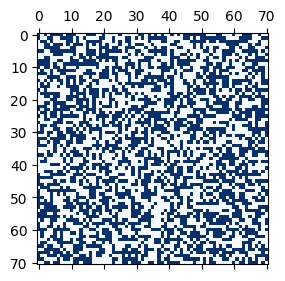

In [5]:
input_mtx = np.array(data)
input_mtx[input_mtx == "."] = 0
input_mtx[input_mtx == "#"] = 1
input_mtx = input_mtx.astype("int")
plot_mtx(input_mtx, (3, 3))

In [6]:
org_mtx = np.c_[
    np.zeros_like(input_mtx),
    np.zeros_like(input_mtx),
    input_mtx,
    np.zeros_like(input_mtx),
    np.zeros_like(input_mtx),
]
org_mtx = np.r_[
    np.zeros_like(org_mtx),
    np.zeros_like(org_mtx),
    org_mtx,
    np.zeros_like(org_mtx),
    np.zeros_like(org_mtx),
]
org_mtx.shape

(355, 355)

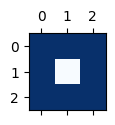

In [7]:
filter_donothing = np.array([[1, 1, 1], [1, 0, 1], [1, 1, 1]])
plot_mtx(filter_donothing, (1, 1))

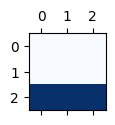

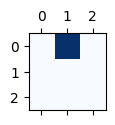

In [8]:
filter_north = np.array([[0, 0, 0], [0, 0, 0], [1, 1, 1]])
move_north = np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]])
plot_mtx(filter_north, (1, 1))
plot_mtx(move_north, (1, 1))

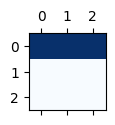

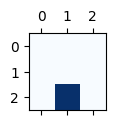

In [9]:
filter_south = np.array([[1, 1, 1], [0, 0, 0], [0, 0, 0]])
move_south = np.array([[0, 0, 0], [0, 0, 0], [0, 1, 0]])
plot_mtx(filter_south, (1, 1))
plot_mtx(move_south, (1, 1))

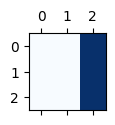

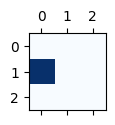

In [10]:
filter_west = np.array([[0, 0, 1], [0, 0, 1], [0, 0, 1]])
move_west = np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]])
plot_mtx(filter_west, (1, 1))
plot_mtx(move_west, (1, 1))

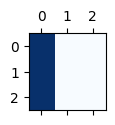

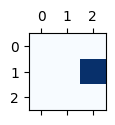

In [11]:
filter_east = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]])
move_east = np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]])
plot_mtx(filter_east, (1, 1))
plot_mtx(move_east, (1, 1))

In [12]:
def move_one_round(pre_mtx, filter_direction_li):
    donothing_mtx = (
        convolve2d(pre_mtx, filter_donothing, mode="same", boundary="fill", fillvalue=0)
        == 0
    ) & pre_mtx

    maymove_mtx = (donothing_mtx == 0) & pre_mtx
    new_pos_mtx = np.zeros_like(maymove_mtx, dtype="int")

    for filter_direction, filter_move in filter_direction_li:
        willmove_mtx = (
            convolve2d(
                pre_mtx, filter_direction, mode="same", boundary="fill", fillvalue=0
            )
            == 0
        ) & maymove_mtx
        new_pos_mtx += convolve2d(
            willmove_mtx, filter_move, mode="same", boundary="fill", fillvalue=0
        )
        maymove_mtx = (willmove_mtx == 0) & maymove_mtx

    conflict_pos = new_pos_mtx > 1
    cancel_move_pos = np.zeros_like(conflict_pos, dtype="int")

    for _, filter_move in filter_direction_li:
        cancel_move_pos += convolve2d(
            conflict_pos, filter_move, mode="same", boundary="fill", fillvalue=0
        )

    cancel_move_pos = cancel_move_pos & pre_mtx

    new_mtx = donothing_mtx | (new_pos_mtx == 1) | maymove_mtx | cancel_move_pos

    return np.array_equal(new_mtx, pre_mtx), new_mtx

In [13]:
def count_space(pos_mtx):
    board_pos = np.where(pos_mtx == 1)
    pos_mtx = pos_mtx[
        board_pos[0].min() : board_pos[0].max() + 1,
        board_pos[1].min() : board_pos[1].max() + 1,
    ]

    plot_mtx(
        pos_mtx,
        (5, 5),
    )
    return pos_mtx.shape[0] * pos_mtx.shape[1] - pos_mtx.sum()

Answer to Q1: 4045

Answer to Q2: 963

CPU times: user 35.1 s, sys: 298 ms, total: 35.4 s
Wall time: 34.9 s


15173

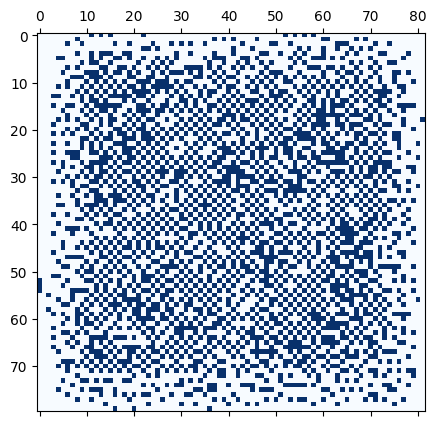

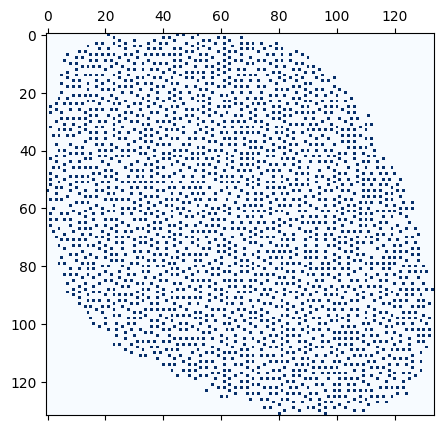

In [14]:
%%time
pos_mtx = org_mtx.copy()
q1_round_num = 10

filter_direction_li = deque(
    [
        (filter_north, move_north),
        (filter_south, move_south),
        (filter_west, move_west),
        (filter_east, move_east),
    ]
)
round_num = 1
while True:
    nomove_flag, pos_mtx = move_one_round(pos_mtx, filter_direction_li)
    filter_direction_li.rotate(-1)
    if round_num == q1_round_num:
        print(f"Answer to Q1: {count_space(pos_mtx)}")
    if nomove_flag:
        print(f"Answer to Q2: {round_num}")
        break
    else:
        round_num += 1

count_space(pos_mtx)